# Titanic (lightGBM classifier)
* Notebook: https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/notebook/lightgbm_classifier_titanic.ipynb
* kaggle: https://www.kaggle.com/c/titanic
* lightgbm: https://lightgbm.readthedocs.io/en/latest/

[<img src="https://github.com/microsoft/LightGBM/raw/master/docs/logo/LightGBM_logo_black_text_small.png">](https://lightgbm.readthedocs.io/en/latest/)

---
* author:  [Prasert Kanawattanachai](prasert.k@chula.ac.th)
* YouTube: https://www.youtube.com/prasertcbs
* github: https://github.com/prasertcbs/
* [Chulalongkorn Business School](https://www.cbs.chula.ac.th/en/)
---

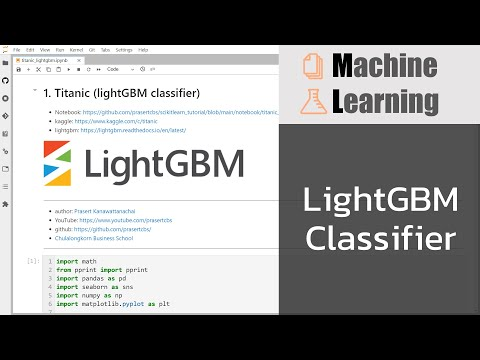

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('yJKRTZW_juc', width=720, height=405)

In [2]:
import math
from pprint import pprint
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pandas  version: 1.2.3
numpy   version: 1.19.2
seaborn version: 0.11.1


## utility functions

In [5]:
def df_unique_value(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            print(f'{c:10}\n{df[c].unique()}')
            print('-' * 65)
            
def convert_cols_to_category(df, cols:list):
    """
    convert `cols` to `category`
    """
    for c in df[cols]:
        df[c] = df[c].astype('category')
    return df
    
def convert_obj_columns_to_category(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')
    return df

def print_category_columns(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type.name == 'category':
    #         print(f'{c}: {df[c].cat.categories}')
    #         print(pd.Series(df[c].cat.categories))
            print(f'{c:15}: {list(enumerate(df[c].cat.categories))}')
            print('-' * 60)
            
def plot_mn(df, cols, n_rows:int=1, kind:str='boxplot', color='salmon'):
    """
    plot boxplot, violin, hist in m (rows) by n (columns)
    >>> plot_mn(df, ['Calories', 'Fat'], 2, 'hist')
    """
    n=len(cols)
    n_cols=math.ceil(n / n_rows)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
    ax=ax.ravel()

    fig.tight_layout()
    for i, c in enumerate(cols):
        col_type = df[c].dtype
        if col_type.name == 'category':
            sns.countplot(data=df, x=c, ax=ax[i])
        else:
            if kind.lower()=='boxplot':
                sns.boxplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='violin':
                sns.violinplot(data=df[[c]], ax=ax[i], color=color)   
            elif kind.lower()=='hist':
                sns.distplot(df[c], hist=True, kde=False, ax=ax[i], color=color)  


## data
| Variable | Definition                                                             | Key                                            |
|----------|------------------------------------------------------------------------|------------------------------------------------|
| Survived | Survival                                                               | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                                                           | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                                                    |                                                |
| Age      | Age in years                                                           |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic                             |                                                |
|          | Sibling = brother, sister, stepbrother, stepsister                     |                                                |
|          | Spouse = husband, wife (mistresses and fiancés were ignored)           |                                                |
| Parch    | # of parents / children aboard the Titanic                             |                                                |
|          | Parent = mother, father                                                |                                                |
|          | Child = daughter, son, stepdaughter, stepson                           |                                                |
|          | Some children travelled only with a nanny, therefore parch=0 for them. |                                                |
| Ticket   | Ticket number                                                          |                                                |
| Fare     | Passenger fare                                                         |                                                |
| Cabin    | Cabin number                                                           |                                                |
| Embarked | Port of Embarkation                                                    | C = Cherbourg, Q = Queenstown, S = Southampton |

In [6]:
df=pd.read_csv('https://github.com/prasertcbs/basic-dataset/raw/master/titanic_train.csv')
df.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
719,720,0,3,"Johnson, Mr. Malkolm Joackim",male,33.00,0,0,347062,7.7750,NaN,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
883,884,0,2,"Banfield, Mr. Frederick James",male,28.00,0,0,C.A./SOTON 34068,10.5000,NaN,S
442,443,0,3,"Petterson, Mr. Johan Emil",male,25.00,1,0,347076,7.7750,NaN,S
360,361,0,3,"Skoog, Mr. Wilhelm",male,40.00,1,4,347088,27.9000,NaN,S
377,378,0,1,"Widener, Mr. Harry Elkins",male,27.00,0,2,113503,211.5000,C82,C
173,174,0,3,"Sivola, Mr. Antti Wilhelm",male,21.00,0,0,STON/O 2. 3101280,7.9250,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.00,0,0,PC 17754,34.6542,A5,C
258,259,1,1,"Ward, Miss. Anna",female,35.00,0,0,PC 17755,512.3292,NaN,C
777,778,1,3,"Emanuel, Miss. Virginia Ethel",female,5.00,0,0,364516,12.4750,NaN,S


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### convert obj/string columns to category data type for lightGBM

In [8]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
cols_to_cat=['Pclass', 'Sex', 'Embarked']

convert_cols_to_category(df, cols_to_cat)
print_category_columns(df)

Pclass         : [(0, 1), (1, 2), (2, 3)]
------------------------------------------------------------
Sex            : [(0, 'female'), (1, 'male')]
------------------------------------------------------------
Embarked       : [(0, 'C'), (1, 'Q'), (2, 'S')]
------------------------------------------------------------


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: category(3), float64(2), int64(4), object(3)
memory usage: 65.8+ KB


In [11]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

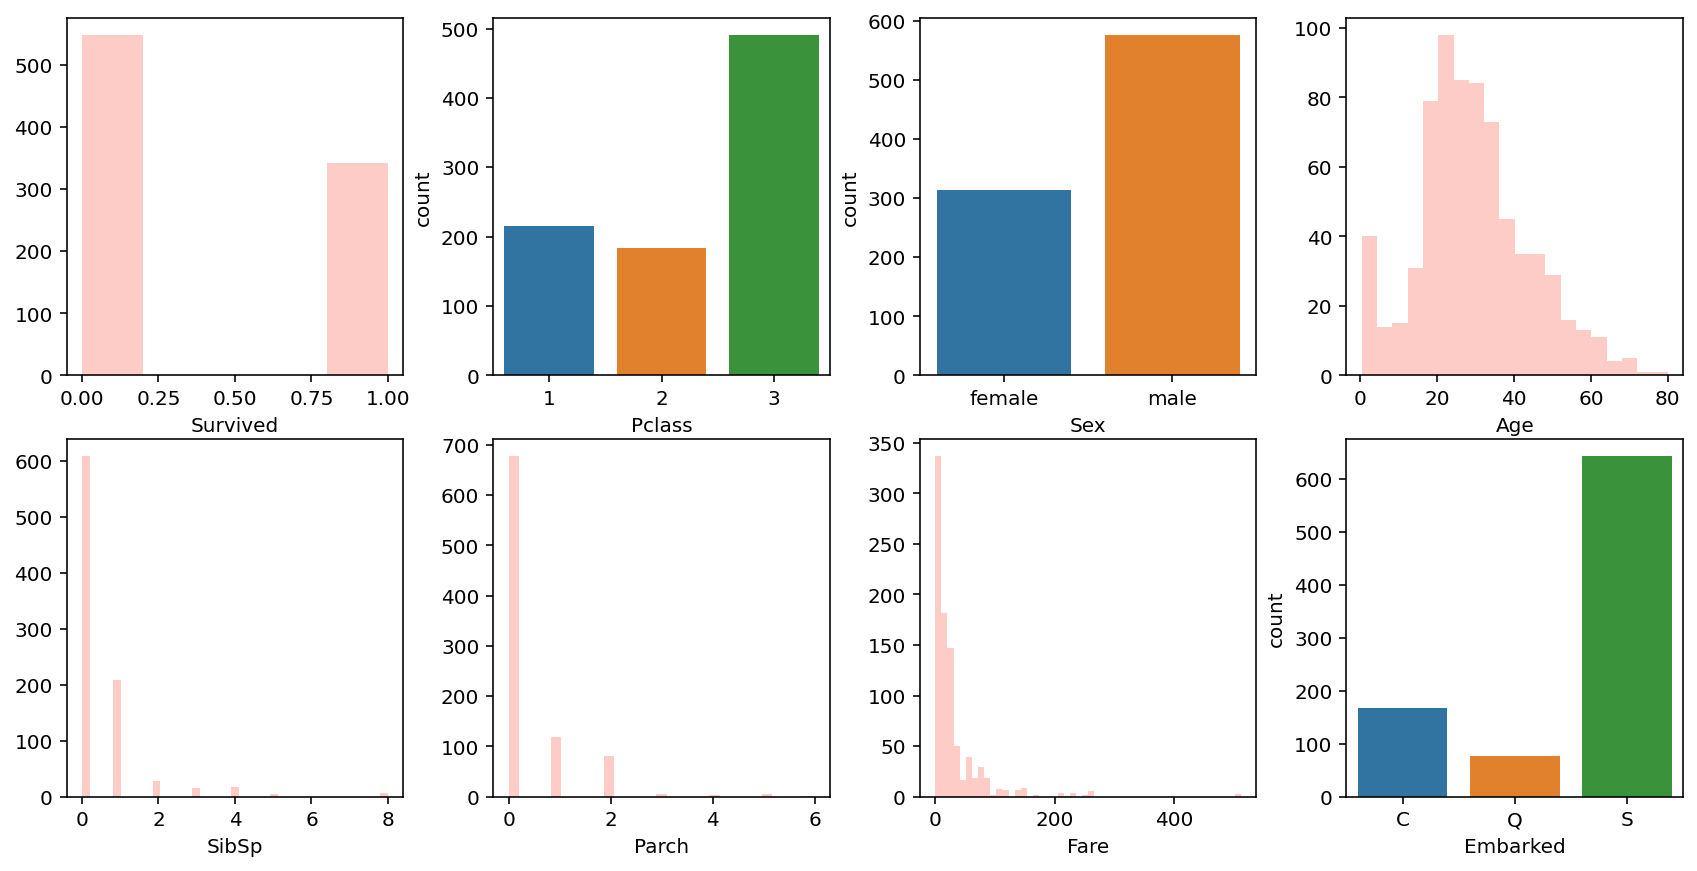

In [12]:
cols=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked']
plot_mn(df, cols, 2, 'hist')

## lightgbm
* `lightGBM` doc: https://lightgbm.readthedocs.io/en/latest/
* `LGBMClassifier`: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier


how to install lightgbm
* pip: `pip install -U lightgbm`
* conda: `conda install lightgbm`

In [13]:
import lightgbm as lgb
print(f'lightgbm version {lgb.__version__}')

lightgbm version 3.1.1


In [14]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, cross_val_score, cross_val_predict, cross_validate
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, f1_score

In [15]:
df[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [17]:
feature_cols=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']
target_col='Survived'

X=df[feature_cols]
y=df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=1, 
                                                    stratify=y)

In [18]:
y_train.value_counts()

0    439
1    273
Name: Survived, dtype: int64

In [19]:
clf=lgb.LGBMClassifier()

In [20]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [21]:
# tuning parameters: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# https://sites.google.com/view/lauraepp/parameters
params={'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# clf = lgb.LGBMClassifier(**params)

In [22]:
# eval_metric: https://lightgbm.readthedocs.io/en/latest/Parameters.html?highlight=metric#metric-parameters
fit_params={'early_stopping_rounds':20, 
            'eval_metric': 'auc', # [binary_logloss, auc]
            'eval_set': [(X_test, y_test)],
            'verbose': 10
           }

clf.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 20 rounds
[10]	valid_0's auc: 0.858893	valid_0's binary_logloss: 0.460133
[20]	valid_0's auc: 0.870817	valid_0's binary_logloss: 0.416874
[30]	valid_0's auc: 0.869104	valid_0's binary_logloss: 0.410102
[40]	valid_0's auc: 0.873123	valid_0's binary_logloss: 0.407059
[50]	valid_0's auc: 0.876943	valid_0's binary_logloss: 0.40744
[60]	valid_0's auc: 0.870751	valid_0's binary_logloss: 0.41314
Early stopping, best iteration is:
[45]	valid_0's auc: 0.876021	valid_0's binary_logloss: 0.4042


LGBMClassifier()

In [23]:
clf.__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': None,
 'n_jobs': -1,
 'silent': True,
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x20a004b3588>,
 '_evals_result': {'valid_0': OrderedDict([('auc',
                [0.8516469038208169,
                 0.853030303030303,
                 0.8610671936758894,
                 0.8586956521739131,
                 0.863965744400527,
                 0.8616600790513834,
                 0.8603425559947299,
                 0.8578392621870883,
                 0.8557312252964426,
                 0.8588932806324111,
                 0.8604743083003953,
                 0.8629776021080369,
                 0.861330

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

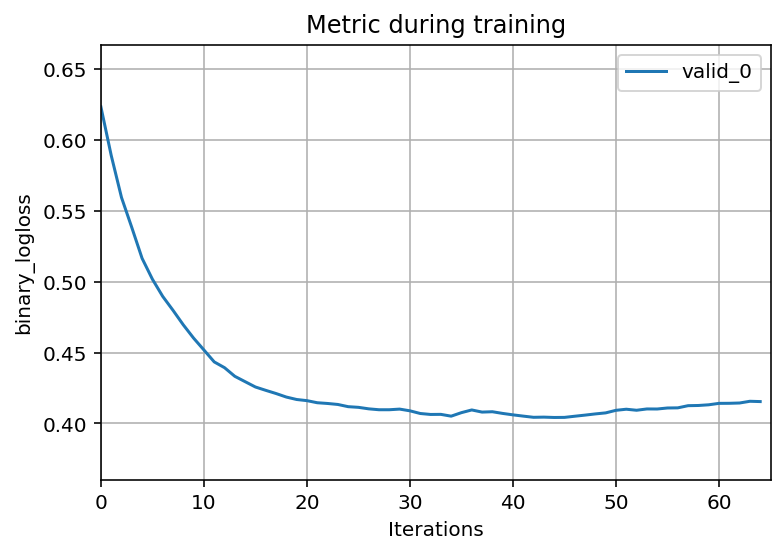

In [24]:
lgb.plot_metric(clf, metric='binary_logloss')

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

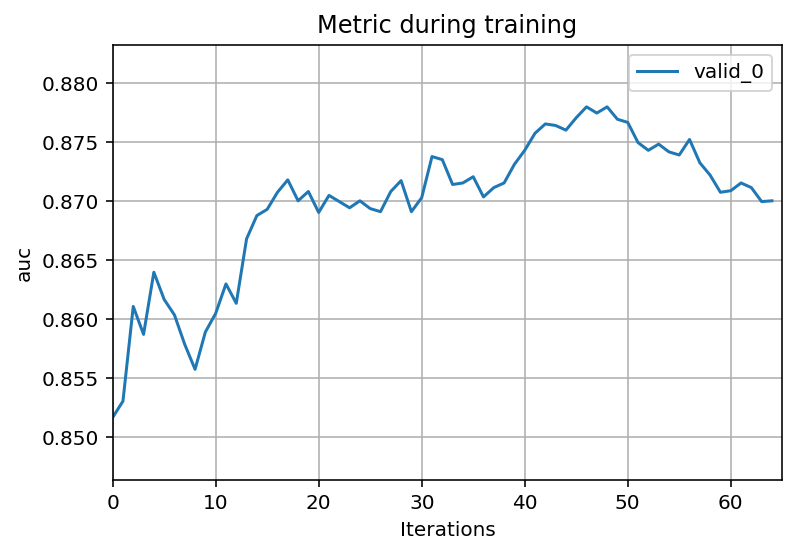

In [25]:
lgb.plot_metric(clf, metric='auc')

In [26]:
clf.score(X_train, y_train) # classification accuracy score

0.8721910112359551

In [27]:
clf.score(X_test, y_test) # classification accuracy score

0.8379888268156425

In [28]:
clf.predict(X_test)[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
      dtype=int64)

In [29]:
clf.predict_proba(X_test)[:20]

array([[0.8972869 , 0.1027131 ],
       [0.78551423, 0.21448577],
       [0.8302463 , 0.1697537 ],
       [0.97032339, 0.02967661],
       [0.92501217, 0.07498783],
       [0.91523347, 0.08476653],
       [0.80000957, 0.19999043],
       [0.80256462, 0.19743538],
       [0.97486419, 0.02513581],
       [0.89895833, 0.10104167],
       [0.07055495, 0.92944505],
       [0.80256462, 0.19743538],
       [0.65874503, 0.34125497],
       [0.93541301, 0.06458699],
       [0.02440585, 0.97559415],
       [0.74736749, 0.25263251],
       [0.94316966, 0.05683034],
       [0.18327372, 0.81672628],
       [0.43761679, 0.56238321],
       [0.97486419, 0.02513581]])

### confusion matrix
$$
\begin{bmatrix}
C_{0,0} & C_{0,1} \\
C_{1,0} & C_{1,1}
\end{bmatrix}
=
\begin{bmatrix}
tn&fp \\
fn&tp
\end{bmatrix}
$$

<table>
<tr>
    <td></td>
    <td>predicted false</td>
    <td>predicted true</td>
</tr>
<tr>
    <td>actual false</td>
    <td>tn</td>
    <td>fp</td>
</tr>
<tr>
    <td>actual true</td>
    <td>fn</td>
    <td>tp</td>
</tr>
<table>

In [30]:
cm=confusion_matrix(y_test, clf.predict(X_test))
cm

array([[98, 12],
       [17, 52]], dtype=int64)

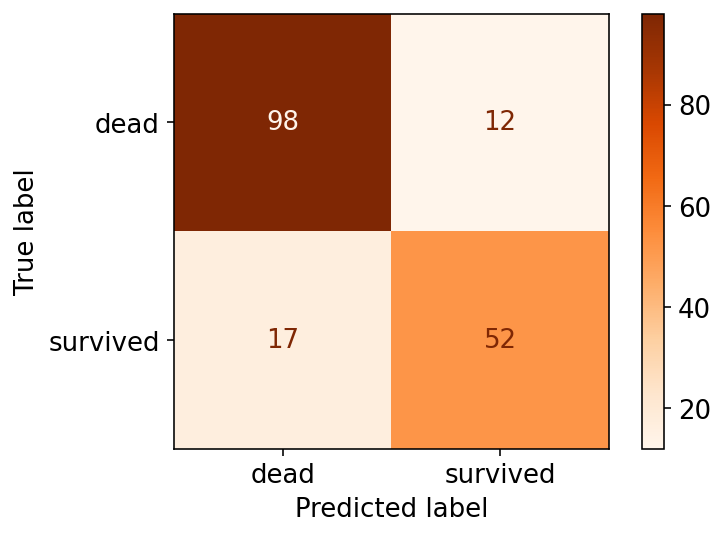

In [31]:
plt.rcParams['font.size']=13
plot_confusion_matrix(clf, X_test, y_test, cmap='Oranges', display_labels=['dead', 'survived']);

$$
\begin{align}
\text {Accuracy}&={\frac {{TP+TN} }{TP + TN +FP + FN} }\\
\text {Precision}&={\frac {TP}{TP+FP}}\\
\text {Recall, True Positive Rate (TPR), sensitivity}&={\frac {TP}{TP+FN}}\\
\text {False Positive Rate (FPR), miss rate}&={\frac {FP}{FP+TN}}\\
F1&=2 \times {\frac {precision \times recall} {precision + recall}}\\
\end{align}
$$

$$
\begin{align}
Recall_0&={\frac {TN}{TN+FP}}\\
Recall_1&={\frac {TP}{TP+FN}}\\
Precision_0&={\frac {TN}{TN+FN}}\\
Precision_1&={\frac {TP}{TP+FP}}\\
\end{align}
$$

In [32]:
print(classification_report(y_train, clf.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       439
           1       0.87      0.78      0.82       273

    accuracy                           0.87       712
   macro avg       0.87      0.86      0.86       712
weighted avg       0.87      0.87      0.87       712



In [33]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

